#  2017-11-10  Regularization

The goal of this lab is to explore and understand l1 and l2 regularization of linear models.

The lab starts with a classification example using scikit-learn, which should be your focus. You can then use it to explore regression examples (Bonus 1), understand how to implement these algorithms (Bonus 2), combine feature selection (PCA) and logistic/linear regression with scikit-learn pipelines (Bonus 3). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Classification data

We will use the same data as in Lab 4: the samples are tumors, each described by the expression (= the abundance) of 3,000 genes. The goal is to separate the endometrium tumors from the uterine ones.

In [2]:
# load the endometrium vs. uterus tumor data
endometrium_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
endometrium_data.head(n=5)  # adjust n to view more data

,ID_REF,1554530_at,1553185_at,1554340_a_at,1556202_at,1553957_at,1555469_a_at,1553660_at,1554681_a_at,1554938_a_at,...,1553967_at,1553362_at,1553002_at,1556194_a_at,1556420_s_at,1555855_at,1554508_at,1555097_a_at,1556371_at,Tissue
0,117722,10.8,13233.7,27.2,167.8,450.7,283.8,6.4,8.6,26.7,...,165.2,43.7,77.0,42.2,154.8,266.6,444.0,66.9,50.6,Endometrium
1,76638,12.6,4986.8,1.7,221.1,380.8,394.3,121.2,8.0,153.8,...,190.7,3.2,84.0,183.0,288.0,20.6,99.3,6.4,12.2,Endometrium
2,88952,16.6,6053.8,121.4,342.7,217.6,367.9,159.7,10.8,124.4,...,95.9,17.1,72.3,292.9,209.5,11.6,51.3,33.8,33.4,Endometrium
3,76632,9.9,6109.1,23.0,139.3,501.8,289.9,101.7,9.7,204.8,...,235.1,37.9,81.5,109.3,537.7,58.7,73.9,58.9,15.4,Endometrium
4,88966,13.1,8430.9,17.4,29.4,449.1,248.2,104.1,11.2,94.5,...,125.0,59.9,186.8,122.5,355.2,65.1,139.9,14.1,11.2,Endometrium


In [3]:
# Create the design matrix and target vector
X_clf = endometrium_data.drop(['ID_REF', 'Tissue'], axis=1).values
y_clf = pd.get_dummies(endometrium_data['Tissue']).values[:,1]

__Question:__ Split the data in a train set containing 70% of the data and a test set containing the remaining 30%. We use [model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split_)

In [4]:
from sklearn import model_selection
Xtr, Xte, ytr, yte = model_selection.train_test_split(X_clf, y_clf, 
                                                      test_size=0.3, 
                                                      random_state=27)

Let us also compute a scaled version of the data. The data is scaled on the _train_ set, and the scaling parameters (mean, standard deviation) are applied to the test set. __Question:__ Why?

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)
Xte_scaled = scaler.transform(Xte)

# 2. Logistic regression, not regularized 

Let us train a logisitic regression _without regularization_ on our train set, and evaluate it on the test set. This is similar to Lab 4 and will serve as a comparison point.

In [6]:
# Logistic regression (no regularization, no scaling)
from sklearn import linear_model
clf_logreg = linear_model.LogisticRegression(C=1e6) # large C = no regularization

# Train the model
clf_logreg.fit(Xtr, ytr)

# Predict on the test set
# Predicted probabilities of belonging to the positive class
pos_idx = list(clf_logreg.classes_).index(1)
ypred_logreg = clf_logreg.predict_proba(Xte)[:, pos_idx]

# Predicted binary labels
ypred_logreg_b = np.where(ypred_logreg > 0.5, 1, 0)

from sklearn import metrics
print("No regularization: accuracy = %.3f" % metrics.accuracy_score(yte, ypred_logreg_b))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg)))

No regularization: accuracy = 0.636
AUC = 0.642


__Question:__ Repeat the experiment on the scaled data. What do you observe in terms of performance?

In [8]:
# Logistic regression (no regularization, scaling)
clf_logreg_s = linear_model.LogisticRegression(C=1e6)

# Train the model
clf_logreg_s.fit(Xtr_scaled, ytr)

# Predict on the test set
# Predicted probabilities of belonging to the positive class
pos_idx = list(clf_logreg_s.classes_).index(1)
ypred_logreg_s = clf_logreg_s.predict_proba(Xte_scaled)[:, pos_idx]
# Predicted binary labels
ypred_logreg_s_b = np.where(ypred_logreg_s > 0.5, 1, 0)

print("Scaled, no regularization: accuracy = %.3f" % metrics.accuracy_score(yte, ypred_logreg_s_b))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_s)))

Scaled, no regularization: accuracy = 0.782
AUC = 0.859


# 3. L2-regularized logistic regression 

__Question:__ What is the role of L2 regularization?

Let us use an l2-regularized logistic regression with the parameter `C` set to 0.01. 

__Question:__ What is the role of `C`? How does it relate to the `lambda` regularization parameter we have seen in class?

__Question:__ Train the l2-regularized logistic regression initialized below on the scaled training data, and evaluate it on the sclaed test set (as above). How does the performance evolve?

In [28]:
cvalue = 0.01
clf_logreg_l2_s = linear_model.LogisticRegression(C=cvalue, penalty='l2')

# Train the model
clf_logreg_l2_s.fit(Xtr_scaled, ytr)

# index of positive class
pos_idx = list(clf_logreg_l2_s.classes_).index(1)
# predict probability of being positive
ypred_logreg_l2_s = clf_logreg_l2_s.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary labels
ypred_logreg_l2_s_b = np.where(ypred_logreg_l2_s > 0.5, 1, 0)

print("Scaled, l2 regularization (C=%.2e): accuracy = %.3f" % (cvalue, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l2_s_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l2_s)))

Scaled, l2 regularization (C=1.00e-02): accuracy = 0.782
AUC = 0.858


### 3.1 Effect of L2-regularization on the logistic regression coefficients

We will now look at how the regression coefficients have evolved between the non-regularized and the regularized versions of the logistic regression.

__Question:__ Fill in the blanks below to plot the regression coefficients of both the trained `clf_logreg_l2_s` and `clf_logreg_s` models. Use the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to figure out how to access these coefficients. What do you observe?

(0, 3000)

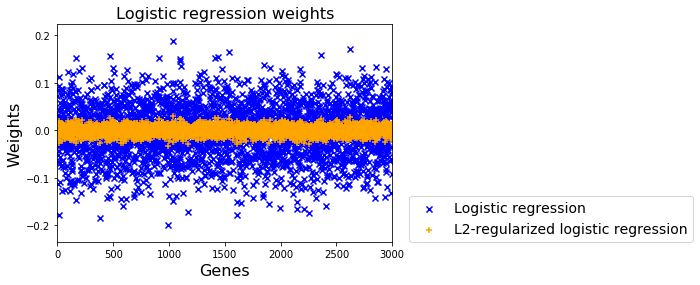

In [29]:
# Effect of l2-regularization on the weights
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg_s.coef_, 
            color='blue', marker='x', label='Logistic regression')
plt.scatter(range(num_features), clf_logreg_l2_s.coef_, 
            color='orange', marker='+', label='L2-regularized logistic regression')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

## 3.2 Optimization of the regularization parameter

We will now use a 3-fold cross-validation on the training set to optimize the value of C. Scikit-learn makes it really easy to use a cross-validation to choose a good value for $\alpha$ among a grid of several choices. Check the [GridSearchCV class](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV).

In [30]:
# Create a range of values to test for the parameter C
cvalues_list = np.logspace(-5, 1, 20)
print(cvalues_list)

[  1.00000000e-05   2.06913808e-05   4.28133240e-05   8.85866790e-05
   1.83298071e-04   3.79269019e-04   7.84759970e-04   1.62377674e-03
   3.35981829e-03   6.95192796e-03   1.43844989e-02   2.97635144e-02
   6.15848211e-02   1.27427499e-01   2.63665090e-01   5.45559478e-01
   1.12883789e+00   2.33572147e+00   4.83293024e+00   1.00000000e+01]


__Question:__ Fill in the blanks below to find the optimal value of the parameter C.

Use the `.best_estimator_` attribute of a `GridSearchCV`. 

In [31]:
# Optimize cvalue
classifier = linear_model.LogisticRegression(penalty='l2')
param_grid = {'C': cvalues_list
             }
clf_logreg_l2_s_opt = model_selection.GridSearchCV(classifier, 
                                                   param_grid, 
                                                   cv=3)     

# Train the model
clf_logreg_l2_s_opt.fit(Xtr_scaled, ytr)

# index of the positive class
pos_idx = list(clf_logreg_l2_s.classes_).index(1)
# predict probability of being positive
ypred_logreg_l2_s_opt = clf_logreg_l2_s_opt.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary label
ypred_logreg_l2_s_opt_b = np.where(ypred_logreg_l2_s_opt > 0.5, 1, 0)

# optimal value of C
cvalue_opt = clf_logreg_l2_s_opt.best_params_['C']
print("Scaled, l2 regularization (C=%.2e): accuracy = %.3f" % (cvalue_opt, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l2_s_opt_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l2_s_opt)))

Scaled, l2 regularization (C=3.79e-04): accuracy = 0.818
AUC = 0.861


__Question:__ Fill in the code below to compare the ROC curves of the non-regularized and l2-regularized logistic regressions.

In [32]:
fpr_logreg_s, tpr_logreg_s, t = # TODO
auc_logreg_s = metrics.auc(fpr_logreg_s, tpr_logreg_s)
plt.plot(fpr_logreg_s, tpr_logreg_s, color='blue', 
         label='No regularization: AUC = %0.3f' % auc_logreg_s)

fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, t = # TODO
auc_logreg_l2_s_opt = metrics.auc(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt)
plt.plot(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, color='orange', 
         label='L2 regularization: AUC = %0.3f' % auc_logreg_l2_s_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(fontsize=14)

SyntaxError: invalid syntax (<ipython-input-32-e78537a870df>, line 1)

__Question:__ Is the optimal C larger or smaller than the one we tried before? Does this mean more or less regularization? Do you expect larger or smaller regularization coefficients?

__Question:__ Fill in the blanks to compare the regularization weights of the different methods.

In [ ]:
# Effect of l2-regularization on the weights
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg.coef_, 
            color='blue', marker='x', label='Logistic regression')
plt.scatter(range(num_features), clf_logreg_l2_s.coef_, 
            color='orange', marker='+', label='L2-regularized logistic regression')
plt.scatter(range(num_features), clf_logreg_l2_s_opt.best_estimator_.coef_, 
            color='magenta', marker='.', label='L2-regularized logistic regression (opt)')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

# 4. L1-regularized logistic regression

__Question:__ What is the role of the l1-regularized logistic regression?

__Question:__ Instead of a l2-regularized logistic regression with `C=0.01`, now train and evaluate a __l1__-regularized logistic regression with __`C=10.0`__.

In [ ]:
cvalue = 10
clf_logreg_l1_s = linear_model.LogisticRegression(C=1, penalty="l1")
clf_logreg_l1_s.fit(Xtr_scaled, ytr)

# index of the positive class
pos_idx = list(clf_logreg_l1_s.classes_).index(1)
# predict the probability of belonging to the positive class
ypred_logreg_l1_s = clf_logreg_l1_s.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary labels
ypred_logreg_l1_s_b = np.where(ypred_logreg_l1_s > 0.5, 1, 0)

print("Scaled, l1 regularization (C=%.2e): accuracy = %.3f" % (cvalue, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l1_s_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l1_s)))

__Question__: How did the performance evolve?

## 4.1 Effect of regularization on the regression coefficients

__Question:__ Plot the weights that were given to each feature in your data.

In [ ]:
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg.coef_, 
            color='blue', marker='x', label='Logistic regression')
plt.scatter(range(num_features), clf_logreg_l1_s.coef_, 
            color='orange', marker='+', label='L1-regularized logistic regression')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

__Question:__ What do you observe? How does this differ from l2-regularization?

__Question:__ How many weights are different from zero? How many features are _not_ used by the l1-regularized model? 

In [ ]:
# Number of selected features
print("The non-regularized logistic regression uses %d features" % len(np.where(clf_logreg_s.coef_ !=0)[1]))
print("The L2-regularized logistic regression uses %d features" % len(np.where(clf_logreg_l2_s.coef_ !=0)[1]))
print("The L1-regularized logistic regression uses %d features" % len(np.where(clf_logreg_l1_s.coef_ !=0)[1]))

print("Number of features discarded by the L1-regularization: %d" % (3000-len(np.where(clf_logreg_l1_s.coef_ !=0)[1])))

## 4.2 Optimization of the regularization parameter

__Question:__ Fill in the blanks to optimize the value of `C` for l1-regularized logistic regression.

In [34]:
# Optimize cvalue
cvalues_list = np.logspace(-2, 3, 20)
print(cvalues_list)

classifier = linear_model.LogisticRegression(penalty='l1')
param_grid = { 'C': cvalues_list }
clf_logreg_l1_s_opt = model_selection.GridSearchCV(classifier, param_grid,cv=3)

# Train the model
clf_logreg_l1_s_opt.fit(Xtr_scaled, ytr)

# index of the positive class
pos_idx = list(clf_logreg_l1_s_opt.classes_).index(1)
# predict the probability of belonging to the positive class
ypred_logreg_l1_s_opt = clf_logreg_l1_s_opt.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary labels
ypred_logreg_l1_s_opt_b = np.where(ypred_logreg_l1_s_opt > 0.5, 1, 0)

# optimal value of C
cvalue_opt = clf_logreg_l1_s_opt.best_params_['C']

print("Scaled, l1 regularization (C=%.2e): accuracy = %.3f" % (cvalue_opt, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l1_s_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l1_s_opt)))

[  1.00000000e-02   1.83298071e-02   3.35981829e-02   6.15848211e-02
   1.12883789e-01   2.06913808e-01   3.79269019e-01   6.95192796e-01
   1.27427499e+00   2.33572147e+00   4.28133240e+00   7.84759970e+00
   1.43844989e+01   2.63665090e+01   4.83293024e+01   8.85866790e+01
   1.62377674e+02   2.97635144e+02   5.45559478e+02   1.00000000e+03]
Scaled, l1 regularization (C=4.83e+01): accuracy = 0.673
AUC = 0.822


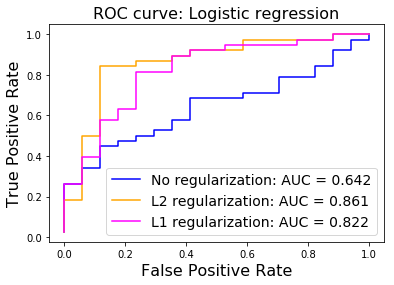

In [39]:
# ROC curve
fpr_logreg_s, tpr_logreg_s, t = metrics.roc_curve(yte, ypred_logreg, pos_label=1)
auc_logreg_s = metrics.auc(fpr_logreg_s, tpr_logreg_s)
plt.plot(fpr_logreg_s, tpr_logreg_s, color='blue', 
         label='No regularization: AUC = %0.3f' % auc_logreg_s)

fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, t = metrics.roc_curve(yte, ypred_logreg_l2_s_opt, pos_label=1)
auc_logreg_l2_s_opt = metrics.auc(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt)
plt.plot(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, color='orange', 
         label='L2 regularization: AUC = %0.3f' % auc_logreg_l2_s_opt)

fpr_logreg_l1_s_opt, tpr_logreg_l1_s_opt, t = metrics.roc_curve(yte, ypred_logreg_l1_s_opt, pos_label=1)
auc_logreg_l1_s_opt = metrics.auc(fpr_logreg_l1_s_opt, tpr_logreg_l1_s_opt)
plt.plot(fpr_logreg_l1_s_opt, tpr_logreg_l1_s_opt, color='magenta', 
         label='L1 regularization: AUC = %0.3f' % auc_logreg_l1_s_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(fontsize=14)

__Question:__ How many genes does the l1-regularized approach select? How does this affect the performance, compared to `C=10.0` or the l2-regularized approach?

In [38]:
print("The L1-regularized logistic regression uses %d features" % len(np.where(clf_logreg_l1_s.coef_ !=0)[1]))
print("The optimized L1-regularized logistic regression uses %d features" % \
      len(np.where(clf_logreg_l1_s_opt.best_estimator_.coef_ !=0)[1])
     )

The L1-regularized logistic regression uses 90 features
The optimized L1-regularized logistic regression uses 247 features


__Question:__ Compare the features selected with `C=0.01` and your optimal `C` value. What do you observe?

(0, 3000)

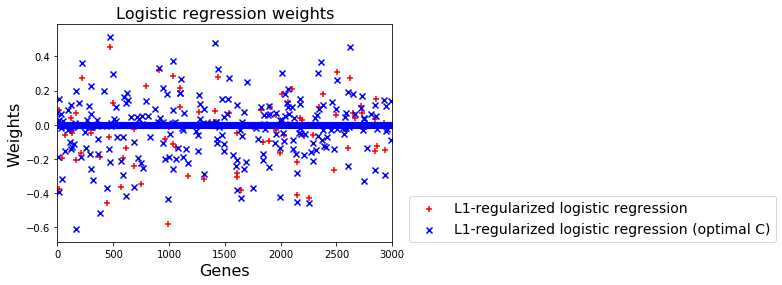

In [42]:
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg_l1_s.coef_, 
            color='red', marker='+', label='L1-regularized logistic regression')
plt.scatter(range(num_features), clf_logreg_l1_s_opt.best_estimator_.coef_, 
            color='blue', marker='x', label='L1-regularized logistic regression (optimal C)')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

# Bonus 1. Regularized regression

Here we guide you in using l1-regularized and l2-regularized linear regressions, aka lasso and ridge regression, respectively, on the same wine quality data as in Lab 4. We also use the same cross-validation set-up as in Lab 4; you might want to try a train/test setup similar to the one we set up here for the gene expression data.

Regularization does not necessarily have much impact on this data set; you can also try this lab with the prostate data (used in the _Elements of Statistical Learning_ textbook), which you can download from https://rafalab.github.io/pages/649/prostate.html. 

In [43]:
# load the data for regression
wine_data = pd.read_csv('data/winequality-white.csv', sep=";")
wine_data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [44]:
X_regr = wine_data.drop(['quality'], axis=1).values
y_regr = wine_data['quality'].values

In [45]:
# Build cross-validation folds
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5)
kf.get_n_splits(X_regr)
folds_regr = [(tr, te) for (tr, te) in kf.split(X_regr)]

In [46]:
# Cross-validation procedure
def cross_validate_regr(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    regressor:  Regressor instance; must have the following methods:
        - fit(X, y) to train the regressor on the data X, y
        - predict(X) to apply the trained regressor to the data X and return estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        regressor.fit(design_matrix[tr,:], labels[tr])
        pred[te] = (regressor.predict(design_matrix[te,:]))
    return pred

In [47]:
# Cross-validation procedure, with standardization
from sklearn import preprocessing
def cross_validate_regr_with_scaling(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  Regressor instance; must have the following methods:
        - fit(X, y) to train the regressor on the data X, y
        - predict_proba(X) to apply the trained regressor to the data X and return predicted values
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr =  labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        pred[te] = (regressor.predict(Xte))
    return pred

$\DeclareMathOperator*{\argmin}{argmin}$

## Bonus 1.1 L2-regularized linear regression (Ridge)
Ridge regression shrinks the regression coefficients by imposing a penalty
on their size. The ridge coefficients minimize a penalized residual sum of squares,

$$\begin{matrix}
\hat{\beta}_{ridge} = \argmin_{\beta}(y-X\beta)^T(y-X\beta) , \\
subject\ to\ \sum^p_{j=1}\beta_j^2\leq t
\end{matrix}$$

Notice that the intercept $\beta_0$ has been left out of the penalty term. Penalization of the intercept would make the  procedure depend on the origin chosen for Y.

(Discussion on laplacian.)
$$ \hat{\beta}_{ridge} = \argmin_{\beta}{(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^p\beta_j^2}$$

** Question: ** use the [scikit learn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to compute the cross validated mean squared error on the wine-quality dataset.

In [48]:
from sklearn import linear_model, metrics

np.random.seed(5)
regr_ridge = linear_model.Ridge()
ypred_ridge = cross_validate_regr(X_regr, y_regr, regr_ridge, folds_regr)
print("RMSE: %.3f" % np.sqrt(metrics.mean_squared_error(y_regr, ypred_ridge)))

RMSE: 0.767


### Setting the $\alpha$ parameter

__Question:__ What does the $\alpha$ parameter correspond to? See the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) for help.

__Question:__ Use GridSearchCV to optimize $\alpha$.

In [49]:
from sklearn.model_selection import GridSearchCV
#TO DO
param_grid = {'alpha': np.logspace(-3, 3, 6)}
regr_ridge_opt = GridSearchCV(regr_ridge, param_grid, cv=3
                            )

**Question** What criterion is used to chose the optimal alpha? See the [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). Try changing this [criterion](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [58]:
regr_ridge_opt = GridSearchCV(linear_model.Ridge(), param_grid, cv=folds_regr, scoring="neg_mean_squared_error")

**Question** Compute the cross-validated predictions of the Ridge Regression with optimized alpha parameter on our data.

In [59]:
np.random.seed(5)
ypred_ridge_opt = regr_ridge_opt.fit(X_regr, y_regr)
print('param=', regr_ridge_opt.best_params_, 'RMSE=', np.sqrt(-1*regr_ridge_opt.best_score_))

param= {'alpha': 0.001} RMSE= 0.763384767958


Note also that best_score is the mean cross-validated score of the best_estimator although we were computing before the mse over all samples in one go by saving the predictions on each fold.

**Question** Compute the _Nested_ cross-validated predictions of the Ridge Regression (with and without standardization) with optimized C parameter on our data. Discuss.

In [62]:
np.random.seed(5)
regr_ridge_opt = GridSearchCV(linear_model.Ridge(), param_grid, scoring="neg_mean_squared_error")
ypred_ridge_opt = cross_validate_regr(X_regr, y_regr, regr_ridge_opt, cv_folds=folds_regr)
print("without scaling:", metrics.mean_squared_error(y_regr, ypred_ridge_opt))

np.random.seed(5)
regr_ridge_stand_opt = GridSearchCV(linear_model.Ridge(), param_grid, scoring="neg_mean_squared_error")
ypred_ridge_stand_opt = cross_validate_regr_with_scaling(X_regr, y_regr, regr_ridge_stand_opt, cv_folds=folds_regr)
print("with scaling:", metrics.mean_squared_error(y_regr,ypred_ridge_stand_opt))

without scaling: 0.58275630395
with scaling: 0.58198951053


### Effect of regularization
What is the effect of L2 regularizaton on the learned weigths ?
** Question: ** plot the distribution of the learned weigths. Discuss.

(0, 11)

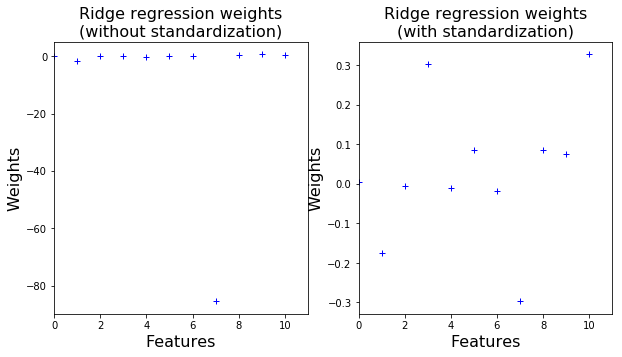

In [64]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)

ridge_weights = regr_ridge_opt.best_estimator_.coef_
number_of_weights = len(regr_ridge_stand_opt.best_estimator_.coef_)

ax.plot(range(number_of_weights), ridge_weights, 
         color='blue', marker='+', linestyle='')
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Ridge regression weights\n(without standardization)', fontsize=16)
ax.set_xlim([0, X_regr.shape[1]])

ax = fig.add_subplot(122)
ridge_weights = regr_ridge_stand_opt.best_estimator_.coef_

ax.plot(range(number_of_weights), ridge_weights, 
         color='blue', marker='+', linestyle='')
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Ridge regression weights\n(with standardization)', fontsize=16)
ax.set_xlim([0, X_regr.shape[1]])

## Bonus 1.2 L1-regularized linear regression (Lasso)
The lasso estimate is defined by

$$\begin{matrix}
\hat{\beta}_{ridge} = \argmin_{\beta}(y-X\beta)^T(y-X\beta) , \\
subject\ to\ \sum^p_{j=1}|\beta_j|\leq t
\end{matrix}$$

We can also write the lasso problem in the equivalent Lagrangian form
    $$ \hat{\beta}_{ridge} = \argmin_{\beta}{(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^p|\beta_j|}$$

** Question: ** use the [scikit learn implementation]() to get the cross validated mean suared error and try to vary the $\alpha$ value.

In [69]:
from sklearn import linear_model

np.random.seed(5)
regr_lasso = linear_model.Lasso(alpha=0.0001)
ypred_lasso = cross_validate_regr(X_regr, y_regr, regr_lasso, folds_regr)
print(metrics.mean_squared_error(y_regr, ypred_lasso))

0.588089833433


** Question: ** Compute the best (by optimizing alpha) nested cross validation performance.

In [70]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-4, 4, 9)}

regr_lasso_opt = GridSearchCV(linear_model.Lasso(), param_grid)
ypred_lasso_opt = cross_validate_regr(X_regr, y_regr, regr_lasso_opt, folds_regr)
print("without standardization; RMSE: ", np.sqrt(metrics.mean_squared_error(y_regr,
                                                                            ypred_lasso_opt)), 
      '; alpha: ', regr_lasso_opt.best_params_['alpha'])
     
regr_lasso_stand_opt = GridSearchCV(linear_model.Lasso(), param_grid)
ypred_lasso_stand_opt = cross_validate_regr_with_scaling(X_regr, y_regr, regr_lasso_stand_opt, folds_regr)
print("with standardization; RMSE: ", np.sqrt(metrics.mean_squared_error(y_regr,
                                                                         ypred_lasso_stand_opt)), 
      '; alpha: ', regr_lasso_stand_opt.best_params_['alpha'])

without standardization; RMSE:  0.766627787987 ; alpha:  0.001
with standardization; RMSE:  0.764298163977 ; alpha:  0.01


### Effect of regularization
What is the effect of L1 regularizaton on the learned weigths ?
** Question: ** plot the distribution of the learned weigths. 

Without standardization, indices of zero weigths (array([4, 7]),)
With standardization, indices of zero weigths (array([2, 6]),)


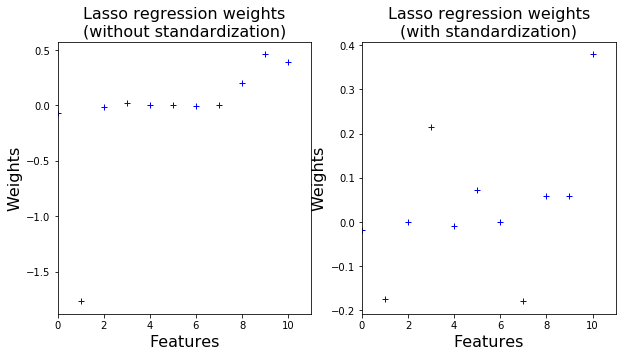

In [73]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)

lasso_weights = regr_lasso_opt.best_estimator_.coef_
number_of_weights = X_regr.shape[1]

ax.plot(range(number_of_weights), lasso_weights, 
         color='blue', marker='+', linestyle='')
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Lasso regression weights\n(without standardization)', fontsize=16)
ax.set_xlim([0, X_regr.shape[1]])
print("Without standardization, indices of zero weigths", np.where(lasso_weights==0))

ax = fig.add_subplot(122)
lasso_weights = regr_lasso_stand_opt.best_estimator_.coef_

ax.plot(range(number_of_weights), lasso_weights, 
         color='blue', marker='+', linestyle='')
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Lasso regression weights\n(with standardization)', fontsize=16)
ax.set_xlim([0, X_regr.shape[1]])
print("With standardization, indices of zero weigths", np.where(lasso_weights==0))

# Bonus 2. Implementation of the regularized regression and classification

## Bonus 2.0 Gradient Descent
Recall the gradient descent class we used in the previous lab. To be able to reuse it, include it here.

In [74]:
class GradientDescentOptimizer():
    """ Class for optimization by gradient descent.
    
    Attributes:
    -----------
    f: function
        the function to optimize
    fprime: function 
        the gradient of the function to optimize
    beta: np.array
        the point where the function is currently being evaluated
    lr: float
        the learning rate
    fx: float
        the current function value
    fgx: np.array
        the current gradient value
    beta_history: list of np.array
        the list of all points where f has been evaluated
    """
    def __init__(self, f, fprime, start, lr=1e-1):
        """     
        Parameters:
        -----------
        f: function
            the function to optimize 
            Yes, we can pass functions as parameters! To call f within the code, use f followed 
            by its arguments enclosed between parentheses, as you would normally do: f(x)
        fprime: function
            the function's gradient
        start: np.array
            the starting point, at which we begin our search
        lr: float
            the learning rate
        """
        # Store the parameters as attributes
        self.f      = f
        self.fprime = fprime
        self.beta   = start
        self.lr     = lr
        # Save history
        self.beta_history = [start]
          
    def compute_fprime(self):
        """ Compute the value of the gradient of f for our current point. 
        Update self.fgx accordingly.
        """
        self.fgx    = self.fprime(self.beta)
    
    def step(self):
        """ Take a gradient descent step. 
        Upgrade self.beta accordingly. 
        """
        # Take a gradient descent step.
        self.compute_fprime()
        d_beta    = -1*self.lr*self.fgx
        self.beta = self.beta + d_beta
        
    def optimize(self, max_iter=1000):
        """Use the gradient descent optimiser to optimise f.
        Update self.f_history and self.beta_history accordingly.
        
        Parameters:
        -----------
        max_iter: int
            Maximum number of iterations.        
        """
        it = 0
        while it < max_iter:
            self.step()
            it = it + 1
            # Update history. 
            self.beta_history += [self.beta]
            
    def print_result(self):
        """ Print out result once optimization is complete.        
        """
        sys.stdout.write(" === Result ===\n")
        sys.stdout.write("Best beta found: " + str(self.beta) +'\n')
        sys.stdout.write("f(best beta) = " + str(self.f(self.beta)) + '\n')
        sys.stdout.write("f\'(best beta) = " + str(self.fprime(self.beta)) + '\n')

$\DeclareMathOperator*{\argmin}{argmin}$

## Bonus  2.1 L2-regularized linear regression (Ridge)
Ridge regression shrinks the regression coefficients by imposing a penalty
on their size. The ridge coefficients minimize a penalized residual sum of squares,

$$\begin{matrix}
\hat{\beta}_{ridge} = \argmin_{\beta}(y-X\beta)^T(y-X\beta) , \\
subject\ to\ \sum^p_{j=1}\beta_j^2\leq t
\end{matrix}$$

Notice that the intercept $\beta_0$ has been left out of the penalty term. Penalization of the intercept would make the  procedure depend on the origin chosen for Y.

This problem is equivalent to:
$$ \hat{\beta}_{ridge} = \argmin_{\beta}{(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^p\beta_j^2}$$

Differentiating with respect to $\beta$ we obtain $$\frac{\partial{RSS\_ridge}}{\partial{\beta}} = -2X^T(y-X\beta) + 2\lambda\beta_j $$

If $X^TX$ is inversible, we obtain a unique solution by setting the first derivative to 0.
$$\hat{\beta} = (X^TX+\lambda\mathbf{I})^{-1}X^Ty$$

The solution adds a positive constant to the diagonal of $X^TX$ before inversion. Notice that this makes the problem nonsingular, even if $X^TX$ is not of full rank.

In [ ]:
from sklearn import metrics

class RidgeRegr():
    """ Class for least-squares linear regression:
    Parameters:
    -----------
    lambda_: float,
        regularization parameter.
    fit_intercept: bool,
        add or not an intercept to the model.
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients of the linear regression (beta)
    """
    def __init__(self,lambda_=1.0,fit_intercept=True):
        self.coef_ = None
        self.lambda_ = lambda_
        self.fit_intercept = fit_intercept
        
    def fit(self,X,y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        if self.fit_intercept==True:
            X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        
        self.coef_ = # TODO
        
    def predict(self,X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        if self.fit_intercept==True:
            X = np.concatenate((X,np.ones((X.shape[0],1))), axis=1)
        return # TODO

The ridge solutions are not equivariant under scaling of the inputs, and so one normally standardizes the inputs before solving. Notice that in that case $\hat{\beta}_{0}$ is $\bar{y}$.

**Question** Use the cross_validate_with_scaling method to cross-validate the logistic regression on our data.

In [ ]:
regr_ridge = # TODO
ypred_ridge_scaled = cross_validate_regr_with_scaling(X_regr, y_regr, regr_ridge, folds_regr)
print("RMSE: %.3f" % np.sqrt(metrics.mean_squared_error(y_regr, ypred_ridge_scaled)))

** Question: ** Implement the sequential version of ridge regression. Complete the class below: 

In [ ]:
from scipy import optimize

class seq_RidgeRegr():
    """ Class for sequential Ridge regression:
    Parameters:
    -----------
    lambda_: float,
        regularization parameter.
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients of the linear regression (beta)
    """
    def __init__(self,lambda_=1.0):
        self.coef_ = None
        self.lambda_ = lambda_
        
    def fit(self,X,y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        X_aug[:X.shape[0], :X.shape[1]] = X
        
        # Get the initial parameter vector. 
        self.coef_ =  # TODO
        
        def f_loss(beta):
            """ Returns the loss function.        
            """
            beta   = np.reshape(beta, [-1,1])
            phi    = np.squeeze(np.dot(X_aug, beta))
            loss   = # TODO
            return loss
        
        def fprime_loss(beta):
            """ Returns the gradient of f_ls at beta.
            IMPORTANT:  The output should have the same shape as beta,
            otherwise our optimiser will not work.
            """
            phi    = np.dot(X_aug, beta.reshape([-1,1]))
            gradient = # TODO
            return gradient
        
        # Initialize the GradientDescentOptimizer
        self.gd    = GradientDescentOptimizer(f_loss, fprime_loss, self.coef_, lr=1*1e-2)
        # Optimize
        self.gd.optimize()
        # Retrieve the result
        self.coef_ = self.gd.beta
        
    def predict(self,X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        X_aug[:X.shape[0], :X.shape[1]] = X
        return # TODO

In [ ]:
# Now apply to the data
np.random.seed(5)
regr_seqridge = # TODO
ypred_ridge_scaled = cross_validate_regr_with_scaling(X_regr, y_regr, regr_seqridge, folds_regr)    # TODO
print("RMSE: %.3f" % np.sqrt(metrics.mean_squared_error(y_regr,ypred_ridge_scaled)))
plt.plot([regr_seqridge.gd.f(x) for x in regr_seqridge.gd.beta_history], 'r-')

** Question: ** compare with the performance obtained with scikit learn implementation.

## Bonus 2.2 L1-regularized linear regression (Lasso)
The lasso estimate is defined by

$$\begin{matrix}
\hat{\beta}_{ridge} = \argmin_{\beta}(y-X\beta)^T(y-X\beta) , \\
subject\ to\ \sum^p_{j=1}|\beta_j|\leq t
\end{matrix}$$

We can also write the lasso problem in the equivalent Lagrangian form
    $$ \hat{\beta}_{ridge} = \argmin_{\beta}{(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^p|\beta_j|}$$

The constraint makes the solutions nonlinear in the $y_i$ , and there is no closed form expression as in ridge regression. Computing the lasso solution is a quadratic programming problem. 

The Lasso regularizer is not differentiable everywhere - it is not differentiable at $\beta = (0, 0, \ldots, 0)$. Thus we should not use gradient descent to optimise it. However, let us try to use it anyway and see what happens. We will see later why this is not appropriate. Complete the class given below. 

In [ ]:
from scipy import optimize

class seq_Lasso():
    """ Class for sequential Lasso:
    Parameters:
    -----------
    lambda_: float,
        regularization parameter.
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients of the linear regression (beta)
    """
    def __init__(self,lambda_=1.0):
        self.coef_ = None
        self.lambda_ = lambda_
        
    def fit(self,X,y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        X_aug[:X.shape[0], :X.shape[1]] = X
        self.coef_ = np.random.normal(size=(X_aug.shape[1],), loc=0.0, scale=1.0)
        
        # Define the loss function. Include np.sum(np.abs(beta)) 
        #   to incorporate L1-regularisation.
        def f_loss(beta):
            # TODO
            return loss
        
        # Define the gradient of the loss function at a given point. 
        def fprime_loss(beta):
            # Define the gradient of the loss function. 
            # Ensure that you return an array of the same shape as beta,
            #    otherwise the optimisation will not work!
            # TODO
            return gradient
        
        # Initialise the GradientDescentOptimizer. 
        self.gd = GradientDescentOptimizer(f_loss, fprime_loss, self.coef_, lr=1e-1)
        # Optimize
        self.gd.optimize()
        # Retrieve the best set of parameters found by the optimiser
        self.coef_ = self.gd.beta
            
    def predict(self,X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        # Again, augment the data matrix first. 
        X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        X_aug[:X.shape[0], :X.shape[1]] = X
        # Make a prediction.
        return # TODO

In [ ]:
# Now apply it to the data
# Use cross_validate_regr_with_scaling.
np.random.seed(5)
regr_lasso = # TODO
ypred_lasso = cross_validate_regr_with_scaling(X_regr, y_regr, regr_lasso, folds_regr)
print(metrics.mean_squared_error(y_regr, ypred_lasso))

**Question: ** compare with the performance obtained with the scikit learn implementation. Look at the learned weights and discuss.

In [ ]:
print(regr_lasso.coef_)

__Question:__ Do you observe the expected behavior? If not, can you think of an explanation?

## Bonus 2.3 L1-Regularized Logistic Regression

In [ ]:
def sigmoid(x):
    """ Sigmoid function.
    
    Parameters:
    -----------
    x: np.array
        input variables
        
    Returns:
    -------
    r: np.array of same dimension as x
        outputs
    """
    # Truncate the very large and very small values of x to avoid overflowing the exponential.
    x[np.where(x > 7e2)] = 7e2
    x[np.where(x < -7e2)] = -7e2
    
    # Compute the sigmoid
    r = 1. / (1 + np.exp(-1*x))
    return r

**Question** Finish implementing the following class.

In [ ]:
import numpy as np

class LogisticRegression_l1reg():
    """ Class for sequential LA-regularized logistic regression:
    Parameters:
    -----------
    lambda_: float,
        regularization parameter.
        
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients of the linear regression (beta)
    classes_: list
        list of class labels
    """
    def __init__(self, lambda_=1.0):
        self.coef_ = None
        self.lambda_ = lambda_
        self.classes_ = [0,1] # only for binary classification
        
    def fit(self,X,y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        n_points = X.shape[0]
        n_vars   = X.shape[1]
        X_aug = np.ones((n_points, n_vars + 1))
        X_aug[:n_points, :n_vars] = X
        coef_ = np.random.normal(size=(X_aug.shape[1],), loc=0.0, scale=1.0)
        
        cl_ids0 = np.where(y == 0)[0]
        cl_ids1 = np.where(y == 1)[0]
        def f_loss(beta):
            phi_0 = sigmoid(np.dot(X_aug[cl_ids0,:], beta.reshape([-1,1])).squeeze())
            phi_1 = sigmoid(np.dot(X_aug[cl_ids1,:], beta.reshape([-1,1])).squeeze())
            loss  = # TODO
            return loss
        
        def fprime_loss(beta):
            # IMPORTANT: The gradient should have the same shape as beta,
            #    otherwise our optimiser will not work.
            phi       = # TODO
            gradient  = # TODO
            return gradient
        
        gd = GradientDescentOptimizer(f_loss, fprime_loss, coef_, lr=1e-1)
        gd.optimize()
        self.coef_ = gd.beta
        
    def predict_proba(self,X):
        """ Make probabilistic predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (probabilities of belonging to class 1)
        """
        X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        X_aug[:X.shape[0], :X.shape[1]] = X
        phi   = sigmoid(np.dot(X_aug, self.coef_.reshape([-1,1])).squeeze())
        
        pred  = # TODO
        return pred

You'll find the utility functions for cross-validation in a classification setting from Lab 4.

In [ ]:
## make folds
from sklearn import model_selection
skf = model_selection.StratifiedKFold(n_splits=5)
skf.get_n_splits(X_clf, y_clf)
folds_clf = [(tr,te) for (tr,te) in skf.split(X_clf, y_clf)]

In [ ]:
# let's redefine the cross-validation procedure
def cross_validate_clf(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:,list(classifier.classes_).index(1)]
    return pred

In [ ]:
from sklearn import preprocessing
# let's redefine the cross-validation procedure with standardization
def cross_validate_clf_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr = labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        classifier.fit(Xtr, ytr)
        pred[te] = (classifier.predict_proba(Xte))[:,list(classifier.classes_).index(1)]
    return pred

**Question** compute the cross-validated predictions of the l1-regularized logistic regression with default parameters on our data.

In [ ]:
clf_logreg_l1reg = # TODO
ypred_logreg_l1reg = cross_validate_clf(X_clf, y_clf, clf_logreg_l1reg, folds_clf)
print("without standardization:", metrics.accuracy_score(y_clf,np.where(ypred_logreg_l1reg > 0.5, 1, 0)))

**Question: ** compare with the performance obtained with the scikit learn implementation. Look at the learned weights and discuss.

In [ ]:
# TODO

# Bonus 3. Classification on dimensionality-reduced data
Going back to the classification on the ovary vs breast cancer data (Lab 1), we consider here the comparison between classification on projected and original data.

In [ ]:
import pandas as pd
data = pd.read_csv('data/small_Breast_Ovary.csv', sep=",")
my_data = data.drop(['ID_REF', 'Tissue'], axis=1)

In [ ]:
y_data = data[['Tissue']]
y_data.head(5)

In [ ]:
y_data = pd.get_dummies(y_data,)
y = y_data.values[:,1]

In [ ]:
from sklearn import cross_validation
skf = cross_validation.StratifiedKFold(y, 5, shuffle=True, random_state=93)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, decomposition

X = my_data.values
X_scaled = preprocessing.scale(X)

pca = decomposition.PCA(n_components=30)
X_projected = pca.fit_transform(X_scaled)

plt.bar(np.arange(30), pca.explained_variance_ratio_)
plt.xlim([-1, 29])
plt.xlabel("Number of PCs", fontsize=16)
plt.ylabel("Fraction of variance explained", fontsize=16)

In [ ]:
for color_name, tissue, tissue_name, index in zip(['blue', 'orange'], [-1, 1], ['breast', 'ovary'],
                                                  [(data.Tissue =='Breast').values, 
                                                   (data.Tissue!='Breast').values]):
    plt.scatter(X_projected[index,0], X_projected[index,1], 
                c=color_name, label=tissue_name)
plt.legend(loc=(1.1, 0), fontsize=14)
plt.xlabel("PC 1", fontsize=16)
plt.ylabel("PC 2", fontsize=16)

In [ ]:
# removing outliers
index1 = np.where(X_projected[:,0]<60)
index2 = np.where(X_projected[:,1]<40)
index = np.intersect1d(index1, index2)

X_wo = X[index,:]
y_wo = y[index]

In [ ]:
for color_name, tissue, tissue_name, index in zip(['blue', 'orange'], [-1, 1], ['breast', 'ovary'],
                                                  [(data.Tissue =='Breast').values, 
                                                   (data.Tissue!='Breast').values]):
    X_plot = X_projected[index,:]
    X_plot = X_plot[X_plot[:,0]<60,:]
    X_plot = X_plot[X_plot[:,1]<40,:]
    plt.scatter(X_plot[:,0], X_plot[:,1], c=color_name, label=tissue_name)
plt.legend(loc=(1.1, 0), fontsize=14)
plt.xlabel("PC 1", fontsize=16)
plt.ylabel("PC 2", fontsize=16)

**Question:** How many PCs do you think are sufficient to represent your data? What do you expect will happen if you use the projection of the gene expressions on these PCs and run a cross-validation of a classification algorithm? Try it out. Is there a risk of overfitting when you do this? 

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty':['l1', 'l2'], 'C':[1e-3, 1e-2, 1e-1, 1., 1e1, 1e2, 1e3]}
clf = GridSearchCV(linear_model.LogisticRegression(), param_grid, n_jobs=3, cv=skf, scoring='roc_auc')

print('trained on original data')
clf.fit(X_scaled, y)
print(clf.best_params_, clf.best_score_)
print(clf.best_params_, np.sort(clf.cv_results_['mean_test_score'])[::-1][0])

clf = GridSearchCV(linear_model.LogisticRegression(), param_grid, n_jobs=3, cv=skf, scoring='roc_auc')
print('trained on projected data')
clf.fit(# TODO
)
print(clf.best_params_, clf.best_score_)
print(clf.best_params_, np.sort(clf.cv_results_['mean_test_score'])[::-1][0])

**Using pipelines**

In order to combine efficiently and correctly dimentionality reduction and classification, we will use a `sklearn.pipeline` to chain `tranformers` objects (must have a `fit` and a `transform` method) with a final predictor object (must have a `fit` and a `predict` method).

This is useful as there is often a fixed sequence of steps in processing the data, for example standardization, feature pre-processing and classification or, feature selection, normalization and classification. By concatenating standardization and classification, pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

Pipeline has `fit` and `predict` methods to be lunch once on your data to fit the corresponding whole sequence of transfromers and estimator. More interestingly, we will grid search over parameters of all transformers and estimator in the pipeline at once.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import preprocessing
estimators = [
    ('preprocessing', preprocessing.StandardScaler()), 
    ('reduce_dim', PCA()), 
    ('clf', linear_model.LogisticRegression())
]
pipe = Pipeline(estimators)
pipe 

The estimators of a pipeline are stored as a list in the steps attribute:

In [ ]:
pipe.steps[0]

and as a dict in named_steps:

In [ ]:
pipe.named_steps['reduce_dim']

Parameters of the estimators in the pipeline can be accessed using the `<estimator>__<parameter>` syntax:

In [ ]:
pipe.set_params(clf__C=10)

Thus, a parameter grid for a pipeline must be implemented as the following.
Notice that individual steps may also be replaced as parameters , and non-final steps may be ignored by setting them to `None`.

In [ ]:
C_OPTIONS = np.logspace(-3, 3, 6)

param_grid = [
              {'preprocessing': [preprocessing.StandardScaler()],
              'reduce_dim': [None],
              'clf': [linear_model.LogisticRegression()],
              'clf__penalty': ['l1', 'l2'],
              'clf__C': C_OPTIONS},
             
              {'preprocessing': [preprocessing.StandardScaler()],
              'reduce_dim': [PCA()],
              'reduce_dim__n_components': [30, 80, 100, 200, 500],
              'clf': [linear_model.LogisticRegression()],
              'clf__penalty': ['l1', 'l2'],
              'clf__C': C_OPTIONS},
             ]

In [ ]:
# be careful, it may take quite a lot of time if the number of tested models is large.
# in such a case, you can reduce the number of tested parameters in "param_grid"

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, cv=skf, n_jobs=3, param_grid=param_grid, scoring='roc_auc')
grid.fit(X, y)

In [ ]:
# plot the score 
data_frame = {name:[] for i in range(len(grid.cv_results_['params'])) for name in grid.cv_results_['params'][i]}
data_frame['score'] = []

sorted_index_score = np.argsort(grid.cv_results_['mean_test_score'])[::-1]
for ind in sorted_index_score:
    data_frame['score'].append(grid.cv_results_['mean_test_score'][ind])
    for name in data_frame.keys():
        if name in grid.cv_results_['params'][ind]:
            data_frame[name].append(grid.cv_results_['params'][ind][name])
        elif name!='score':
            data_frame[name].append(None)
    
pd.DataFrame(data_frame).head(5)

** Question ** What do you observe? Discuss.